# Esame di Analisi Dati in Fisica Subnucleare 2022-09-30
## Tema Python: **Ricostruzione di uno spettrometro magnetico**

Uno spettrometro di massa è uno strumento composto da due o più strazioni di tracciatura poste a monte (*upstream*) e a valle (*downstream*) di un campo magnetico. La posizione e la direzione di volo delle particelle cariche che attraversano lo spettrometro è misurata prima e dopo la deflessione in campo magnetico. Dalla variazione della direzione di volo e noto il campo magnetico si determina la quantità di moto $p$ delle particelle.

In questo esercizio analizzeremo dei dati simulati per lo spettrometro di LHCb con un magnete dipolare che genera una campo magnetico integrato sulla distanza percorsa dalle particelle di circa $4\, \mathrm{T\cdot m}$. Lo scopo è quello di definire e caratterizzare un semplice algoritmo di ricostruzione che permetta di risalire alla quantità di moto di ciascuna particella, nota la direzione di volo a monte e a valle del magnete.

Le variabili rilevanti per lo studio del problema sono:
 * La posizione $(x_U, y_U)$ in cui ciascuna traccia attraversa il tracciatore a monte del campo magnetico
 * la direzione di volo prima della deflessione in campo magnetico, definita con le pendenze $(t_{x,U}, t_{y,U})$, dove
 $$
 t_{x, U} = \left.\frac{\mathrm{d}x}{\mathrm{d}z}\right|_{z = z_U}
 \qquad \mathrm{et} \qquad
 t_{y, U} = \left.\frac{\mathrm{d}y}{\mathrm{d}z}\right|_{z = z_U}
 $$
 e $z$ è la coordinata longitudinale allo spettrometro.
 * la posizione $(x_D, y_D)$ e la direzione di volo $(t_{x,D}, t_{y,D})$
   misurate dopo il magnete
 * La quantità di moto $p_{\mathrm{true}}$ reale delle particelle che attraversano lo spettrometro che cercheremo di approssimare definendo un opportuno algoritmo di ricostruzione.

La definizione delle variabili è schematicamente rappresentata nella figura sotto:

 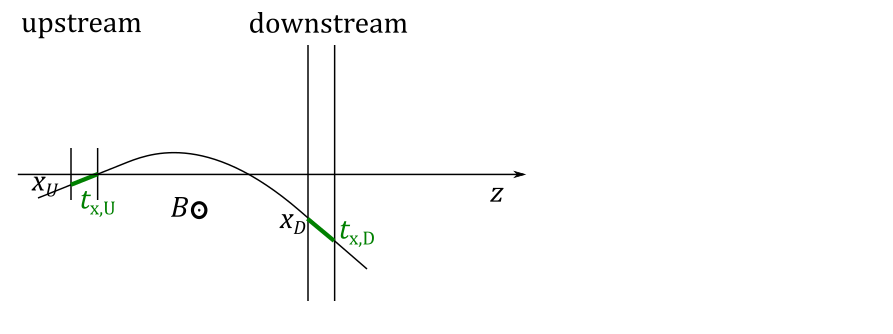

## Caricamento di librerie e dati

Per questo esercizio useremo `numpy`, `scikit-learn` e `pyplot`. Per agevolare il caricamento dei dati utilizzermo anche `pandas`, ma il suo utilizzo non è indispensabile per lo svolgimento dell'esercizio.

I dati sono disponibili in formato `csv` sul sito `pandora` di INFN all'indirizzo: `https://pandora.infn.it/public/546894/dl/spectrometer.csv`

Il dataset contiene le posizioni e le *slope* a monte e a valle del magnete, oltre alla quantità di moto `p_true` con cui è stata simulata ciascuna particella.

Le posizioni sono espresse in millimetri, le pendenze sono numeri puri, la quantità di moto è espressa in $\mathrm{GeV}/c$.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from pandas import read_csv
df = read_csv('https://pandora.infn.it/public/546894/dl/spectrometer.csv')

# Posizione upstream
xU  = df['xU']
yU  = df['yU']

# Slope upstream
txU = df['txU']
tyU = df['tyU']

# Posizione downstream
xD  = df['xD']
yD  = df['yD']

# Slope downstream
txD = df['txD']
tyD = df['tyD']

# Quantità di moto reale
p_true = df['p_true']

## Esercizio 1. Verifica della direzione del campo magnetico

Per verificare che il campo magnetico sia diretto lungo l'asse $y$, si costruiscano e si sovrappongano gli istogrammi della variazione di slope lungo le proiezioni $x$ e $y$.

Dal confronto risulta evidente che lungo una delle due direzioni, la traiettoria è sostanzialmente la medesima prima e dopo il magnete, salvo effetti di risoluzione nella misura.
Lungo l'altra direzione, ortogonale al campo magnetico, la variazione di pendenza è invece significativa.

Il risultato dovrebbe assomigliare al seguente grafico:

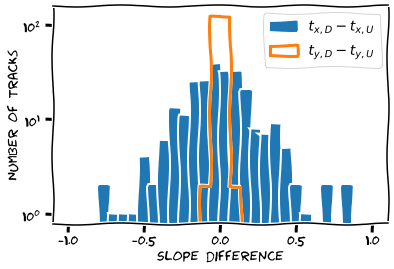

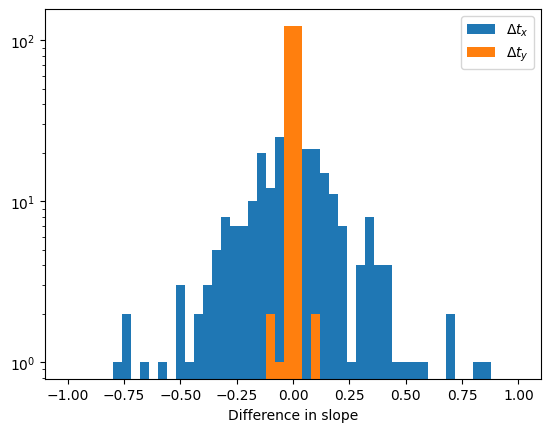

In [ ]:
dtx = txD - txU
dty = tyD - tyU

boundaries = np.linspace(-1, 1, 51)

plt.hist(dtx, bins=boundaries, label="$\Delta t_x$")
plt.hist(dty, bins=boundaries, label="$\Delta t_y$")

plt.yscale('log')

plt.legend()
plt.xlabel("Difference in slope")
plt.show()

## Esercizio 2. Approssimazione $p_{\mathrm{T}}$ kick
Se la quantità di moto è sufficientemente grande, possiamo approssimare l'effetto del campo magnetico su una particella che lo attraversa come una deflessione concentrata in un singolo punto che trasferisce una quantità costante di momento dalla componente $z$ alla componente $x$.
Questa approssimazione è nota in gergo come $p_{\mathrm{T}}$-*kick*.
Ricordiamo che la deflessione in campo magnetico avviene senza cedere energia alla particella, e che quindi la quantità di moto $p$ resta invariata in modulo.

In formule, l'approssimazione $p_{\mathrm{T}}$-*kick* è definita da:
$$p_{x, D} = p_{x, U} \pm \Delta p_x$$
dove il segno di $\Delta p_x$ dipende dalla carica della particella.
Imponendo che il modulo $p$ sia costante, scriviamo:
$$p_{z, D} = \sqrt{p^2 - p_{x,D}^2 - p_{y,D}^2}$$

Per conoscere la componente $x$ della quantità di moto, data la slope è utile un po' di trigonometria:
$$
p_x = p \tan \theta_x \qquad \mathrm{con} \qquad \theta_x = \arcsin t_x
$$

Combinando queste espressioni, otteniamo
$$
\Delta p_x = |p_{x,D} - p_{x,U}| = p|\tan[\arcsin t_{x,D}] - \tan[\arcsin t_{x,U}]|
$$
da cui possiamo definire un problema di regressione scrivendo che
$$
\Delta p_x \ \frac{1}{|\tan[\arcsin t_{x,D}] - \tan[\arcsin t_{x,U}]|} = p
$$
In questa espressione, la frazione a sinistra è la nostra unica variabile indipendente (spesso indicata con $x$), $p$ è la variabile dipendente (spesso indicata con $y$) e $\Delta p_x$ è il coefficiente di proporzionalità che possiamo ottenere con una regressione lineare.


#### Esercizio 2.1.
Per prima cosa definiamo le variabili dipendenti e indipendenti
```
p_true = ...
iv = 1/(...
```

In [ ]:
p_true = p_true
iv = 1. / np.abs(np.tan(np.arcsin(txD)) - np.tan(np.arcsin(txU)))

#### Esercizio 2.2.
Quindi verifichiamo graficamente la relazione di proporzionalità tra `iv` ($|\tan[\arcsin t_{x,D}] - \tan[\arcsin t_{x,U}]|^{-1}$) e `p` costruendo uno *scatter plot* delle due variabili.

Il plot ottenuto dovrebbe assomigliare al seguente

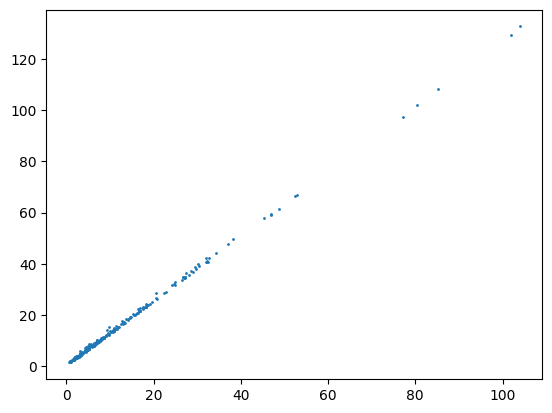

In [ ]:
plt.plot(iv, p_true, 'o', markersize=1)
plt.show()

## Esercizio 3. Regressione lineare
Utilizzando scikit-learn, definire una regressione lineare e ottenere una prima stima per $\Delta p_x$.

#### Esercizio 3.1.
Suddividere il campione in una parte destinata all'addestramento (*training set*) ed in una destinata alla verifica del modello (*test set*).
Le due porzioni di dataset dovrebbero essere statisticamente equivalenti, e contenere approssimativamente lo stesso numero di eventi.


In [ ]:
## Se i valori non sono ordinati in modo random, è meglio sceglierli uniformente nel nostro array
ind = np.arange(len(p_true))
p_true_train = p_true[ind % 2 == 0]
p_true_test = p_true[ind % 2 == 1]


iv_train = iv[ind % 2 == 0]
iv_test = iv[ind % 2 == 1]


## Oppure, se l'ordine è sicuramente casuale
N = len(p_true)
p_true_train = p_true[:int(N/2)]
p_true_test = p_true[int(N/2):]

iv_train = iv[:int(N/2)]
iv_test = iv[int(N/2):]



#### Esercizio 3.2.
Definire una regressione lineare in scikit-learn, avendo cura di vincolare l'intercetta a zero, e addestrare il modello lineare sui dati.

Ottenere una stima per $\Delta p_x$ dai coefficienti del modello addestrato.

In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression(fit_intercept=False)

lr.fit(np.c_[iv_train], p_true_train)

print (f"Il valore stimato per Delta p_x è {lr.coef_[0]:.2f} GeV/c")

Il valore stimato per Delta p_x è 1.28 GeV/c


## Esercizio 4. Studio della funzione risoluzione
Una volta definito un primo, seppur grezzo, algoritmo di ricostruzione, possiamo cercare di caratterizzarlo studiando la funzione di risoluzione.

#### Esercizio 4.1
Iniziamo con il definire i residui del nostro modello:
$$
r_i = \hat p_i - p_{\mathrm{true},\,i}
$$
dove $\hat p$ è lo stimatore ottenuto con la regressione lineare
$$
\hat p_i = \hat{\Delta p_x} \left| \tan[\arcsin t_{x,D}^{(i)}] - \tan[\arcsin t_{x,U}^{(i)}]\right|^{-1}
$$
dove l'indice $i$ definisce la particella (o l'evento) considerata.
```
# Predizione del modello lineare:
p_hat = ...

# Residui
r = ...
```

In [ ]:
delta_px = lr.coef_[0]
p_hat = delta_px * iv

r = p_hat - p_true

#### Esercizio 4.2
Costruire l'istogramma dei residui e calcolare media (`np.mean`) e deviazione standard (si veda `np.std`).

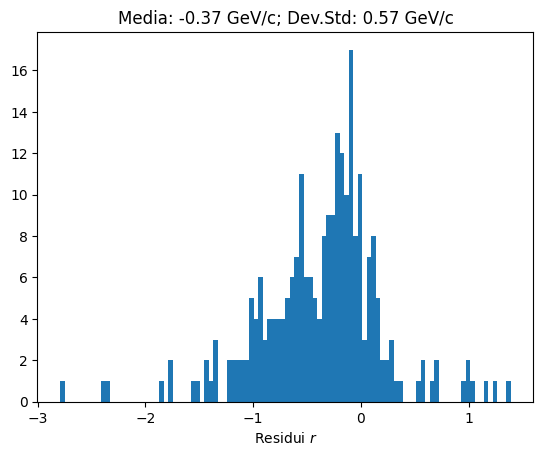

In [ ]:
plt.hist(r, bins=100)
plt.title(f"Media: {np.mean(r):.2f} GeV/c; Dev.Std: {np.std(r):.2f} GeV/c")
plt.xlabel("Residui $r$")
plt.show()

#### Esercizio 4.3
Costruiamo e sovrapponiamo gli scatter plot dei residui *vs.* la quantità di moto simulata per il campione di addestramento ed il campione di test. Dovreste ottenere un grafico simile a quello in figura:


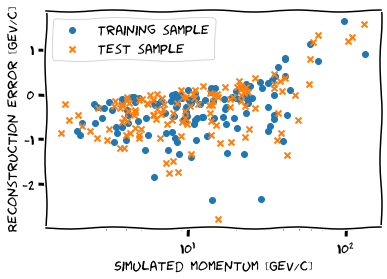

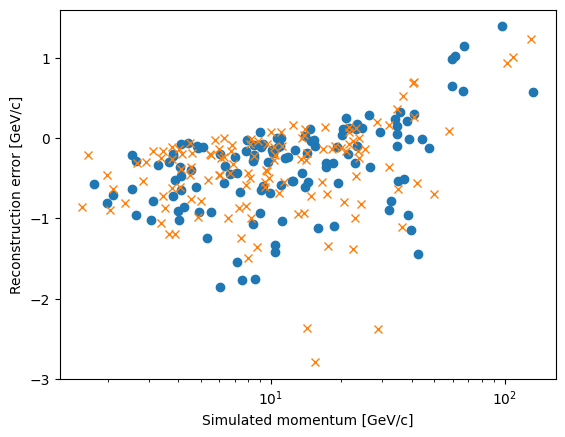

In [ ]:
delta_px = lr.coef_[0]

# Training set
p_hat_train = delta_px * iv_train
r_train = p_hat_train - p_true_train

# Test set
p_hat_test = delta_px * iv_test
r_test = p_hat_test - p_true_test

plt.plot(p_true_train, r_train, 'o', label="Training set")
plt.plot(p_true_test, r_test, 'x', label="Test set")
plt.xscale('log')
plt.xlabel("Simulated momentum [GeV/c]")
plt.ylabel("Reconstruction error [GeV/c]")
plt.show()

## Esercizio 5. Analisi in bin.
Ripetiamo l'analisi della funzione risoluzione (in particolare il calcolo della media e della deviazione standard dei residui) in bin cinematici di quantità di moto, usando come *boundaries*:
$$
p_{\mathrm{boundaries}} = 0, 4, 6, 10, 15, 25\ \mathrm{et}\ 130\  \mathrm{GeV}/c
$$

**Per semplicità, in questo studio si consideri solo il test set**.

#### Esercizio 5.1
Calcolare per le particelle in ciascun bin,
 * media della quantità di moto
 * media dei residui
 * deviazione standard dei residui


Può essere utile seguire la seguente scaletta (ma esistono altre strade altrettanto accettabili, l'importante è arrivare a costrure il grafico richiesto in 5.2):
 * Definire e inizializzare l'array dei boundaries
 * Definire tre liste vuote per i risultati da calcolare (media di $p$, media e deviazione standard dei residui)
 * In un loop su coppie di boundaries (`p_low`, `p_high`):
   * definire un array binario "maschera" che selezioni le particelle nel bin
   * calcolare ed aggiungere alle relative liste le statistiche richieste per le particelle selezionate dalla "maschera"


In [ ]:
mean_p = []
mean_r = []
stddev_r = []

boundaries = np.array([0., 4., 6., 10., 15., 25., 130.])

for p_low, p_high in zip(boundaries[:-1], boundaries[1:]):
  mask = (p_true_test >= p_low) & (p_true_test < p_high)

  p_nel_bin = p_true_test[mask]
  r_nel_bin = r_test[mask]

  mean_p.append(np.mean(p_nel_bin))
  mean_r.append(np.mean(r_nel_bin))
  stddev_r.append(np.std(r_nel_bin))




#### Esercizio 5.2
Costruire un grafico con i valori calcolati al punto precedente.
Dovreste ottenere un grafico simile a quello mostrato sotto.

> Alcuni suggerimenti:
>  * il grafico è ottenuto con `plt.errorbar`
>  * il valore di $x$ è la media del momento in ciascun bin, come calcolato sopra
>  * il valore di $y$ delle due serie "media" e "std. dev." è anch'esso stato calcolato al punto precedente
>  * l'errore su y (`yerr`) può essere lasciato al valore di default `None` così da non mostrare la barra d'errore, oppure può essere imposto a zero
>  * per ottenere le barre d'errore su $x$ asimmetriche si può definire `xerr` come segue:
  ```
  xerr=np.array([(p_center - p_boundaries[:-1]), (p_boundaries[1:] - p_center)])
  ```
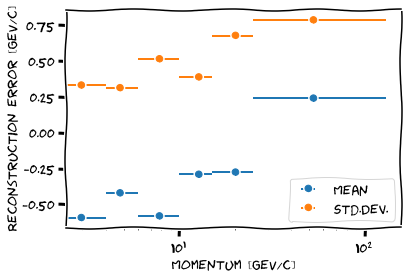

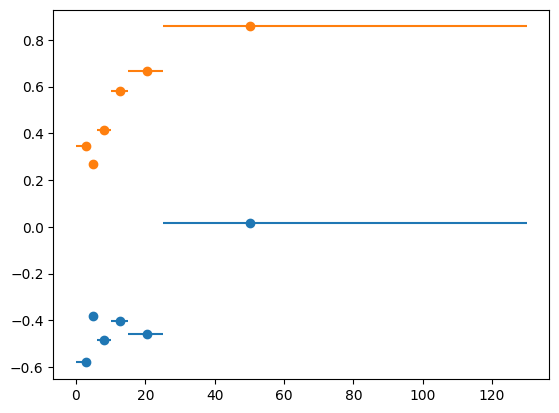

In [ ]:
xerr=np.array([(mean_p - boundaries[:-1]), (boundaries[1:] - mean_p)])

plt.errorbar(mean_p, mean_r, None, xerr, 'o')
plt.errorbar(mean_p, stddev_r, None, xerr, 'o')
plt.show()

## Esercizio 6. Regressione lineare pesata. [**FACOLTATIVO**]
Questo algoritmo di ricostruzione è stato ottenuto con una assunzione molto sbagliata, cioè che l'errore assoluto associato alla misura della quantità di moto sia costante e indipendente dalla quantità di moto stessa. Dal grafico ottenuto nell'esercizio 5 si osserva chiaramente che la deviazione standard dei residui del nostro modello cresce al crescere della quantità di moto.

Possiamo cercare di tenere conto di questa variazione nella regressione lineare, introducendo un peso pari all'inverso del quadrato dell'errore stimato.
Per tentare questa strada, occorre innanzitutto un modello dell'errore, ossia della deviazione standard, in funzione della quantità di moto.


#### Esercizio 6.1. Modello dell'incertezza.

Definire una regressione lineare della deviazione dei residui ottenuta nell'esercizio 5 in funzione della quantità di moto.
> **Suggerimento** I dati da introdurre nella regressione sono esattamente quelli ottenuti nell'esercizio 5.


#### Esercizio 6.2. Regressione pesata

Utilizzare il modello lineare definito in 6.1 per stimare la deviazione standard $\sigma_i$ (che interpretiamo come errore) associata a ciascun elemento del campione di training.

Definire un peso per ciascun elemento del campione di training, secondo la formula:
$$
w_i = \frac{1}{\sigma_i^2}
$$

Infine modificare la regressione implementata nell'esercizio 3 per tenere conto dell'errore. Il codice assomiglierà a:
```
sigma_i = ...
w_i = ...

weighted_model = ...
weighted_model.fit (..., sample_weight=w_i)
```


#### Esercizio 6.3. Caratterizzazione della funzione risoluzione

Ripetere la caratterizzazione in bin della funzione di risoluzione confrontando il risultato ottenuto con e senza l'applicazione dei pesi.

## Conclusione
Gli spettrometri magnetici sono ampiamente utilizzati in fisica delle particelle per misurare la quantità di moto delle particelle cariche che li attraversano.
In questo tema abbiamo abbozzato un semplice algoritmo di ricostruzione basato sull'approssimazione $p_{\mathrm{T}}$-kick e ne abbiamo caratterizzato la funzione di risoluzione al variare della quantità di moto.

L'algoritmo di ricostruzione è molto semplice, ma ci ha permesso di esplorare alcuni passaggi chiave del tutto realistici nella fase di predisposizione di un nuovo rivelatore alla presa dati (*commissioning*). In particolare,
 * preparazione del dataset (definizione delle variabili più adeguate per la ricostruzione);
 * scelta dell'algoritmo di ricostruzione;
 * calibrazione dell'algoritmo su un set di dati (training set);
 * misura della performance dell'algoritmo su un set indipendente (test set);
 * studio della performance in bin delle variabili cinematiche;
 * miglioramento dell'algoritmo sulla base di un modello dell'errore.

Purtroppo, invece, non abbiamo avuto l'opportunità di discutere come definire e propagare le incertezze sperimentali (ad esempio su $t_x$ e $t_y$), che è invece un aspetto fondamentale e cruciale nella ricostruzione dei dati sperimentali.